In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>\
.container { width:90% !important; }\
.rise-enabled {background-color: azure !important;\
    font-size: 125% !important;\
    background-image: url(img/covere.jpg);\
    background-position: right top;\
    background-repeat: no-repeat;\
    background-origin: content-box;\
    padding: 2px 2px 2px 2px;\
}\
.middle{ width: 100px; height: 50px; border: solid 1px red; margin: auto;}\
div.text_cell_render {\
font-family: 'Charis SIL',\
width: 105ex;\
</style>"))

In [2]:
import numpy as np
import gpstk
import matplotlib.pyplot as plt
from IPython.display import display, HTML 
%matplotlib inline

%run -i ./code/utils.py
%run -i ./code/Wallas_Solvers.py
%run -i ./code/WallasUtils.py
%run -i ./code/results_toolkit.py

In [4]:
# MOBJ y MOBK  (inavco)

"""
obsfile1 = "NavFiles/bara0100.17o" 
navfile1 = "NavFiles/bara0100.17n" 

obsfile2 = "NavFiles/tgdr0100.17o"
navfile2 = "NavFiles/tgdr0100.17n"

obsfile1 = "NavFiles/BOGA0100.17O" 
navfile1 = "NavFiles/qui30100.17n" 

obsfile2 = "NavFiles/BEJA0100.17O"
navfile2 = "NavFiles/BEJA0100.17N"
"""
obsfile1 = "../0_bitbucket/NavFiles/unpm0100.17o" 
navfile1 = "../0_bitbucket/NavFiles/unpm0100.17n" 

obsfile2 = "../0_bitbucket/NavFiles/tgmx0100.17o"
navfile2 = "../0_bitbucket/NavFiles/tgmx0100.17n"

# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data1, bcestore1, rec_pos1 = rinex_to_dataframe_iono(obsfile1, navfile1)
# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data2, bcestore2, rec_pos2 = rinex_to_dataframe_iono(obsfile2, navfile2)

data_common = extract_common2(data1, data2)

i = 0
o = data1.iloc[i]
pranges = o.C1

WARNING! observation `C2` no present in file ../0_bitbucket/NavFiles/unpm0100.17o
WARNING! observation `C2` no present in file ../0_bitbucket/NavFiles/tgmx0100.17o


In [5]:
i = 0

dat = copy.deepcopy(data_common.iloc[i])
csats = dat.csats

In [6]:
def baseline(data, rover_pos, Obser="C1", ref_sat_id=0):
    """
    BASELINE Computation of baseline between master and rover 
              from pseudoranges alone
    """
    
    def get_refsat_info(dat, idx):
        """
        dat: dataframe that contains all info from sats at an specific receiver
        idx: It's the index of info to put at begin of dataframe

        I mean that after execute this function, info of refsat allways stay at
        begin of dataframe (dato)
        """
        dato = copy.deepcopy(dat)
        for k, v in dato.iteritems():
            if k != "gps_sow":
                tmp = dato[k][idx].copy()
                dato[k][idx] = dato[k][0].copy()
                dato[k][0] = tmp
        return dato

    def compute_distances(rc, svs):
        return np.linalg.norm(rc-svs, axis=1)

    def predict_pseudoranges(x, prns_pos, prns_clockbias, elevs):
        c = 299792458
        
        def iono_3dmodel(elevs):
            R_earth = 6367444.657  # 6,371 km
            h_iono  = 400e3
            rs, d_iono = R_earth+h_iono, 10e3

            num1 = d_iono**2*(np.sqrt(rs**2*np.cos(elevs))*np.sin(elevs)**2)
            den1 = np.power(2*rs*np.cos(elevs)**2, 3) #8*rs**3*np.cos(elev)**6 # 

            num2 = rs
            den2 = rs*np.cos(elevs)

            return num2/den2 + 1/8*(d_iono/rs)*(d_iono/rs)*np.tan(elevs) #num1/den1
    
        rhos    = compute_distances(x[:3], prns_pos)
        pranges = rhos + x[3]-c*prns_clockbias + iono_3dmodel(elevs)
        return rhos, pranges

    # get refsat for Double differences computations
    dat = get_refsat_info(data, ref_sat_id)
    
    common_sats = dat['csats']
    m = np.shape(common_sats)[0] #len(dat['csats'])
    D = np.hstack((np.ones((m-1, 1)), -np.eye(m-1), -np.ones((m-1, 1)), np.eye(m-1)))
    C = np.linalg.pinv(D.dot(D.T))
    
    # define initial master position from rover position
    rv = np.array(list(rover_pos)+[0.])
    ri = rv
    
    max_iters = 20
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):
        
        # 0 is the reference satellite. 
        # We allways select the first one
        elevs = dat['prns_elev_local'][:1]
        rhok_i, pri = predict_pseudoranges(rv, 
                                           dat['prns_pos_local'][:1], 
                                           dat['prns_clockbias_local'][:1],elevs)
        rhok_j, prj = predict_pseudoranges(ri,
                                           dat['prns_pos_local'][:1], 
                                           dat['prns_clockbias_local'][:1],elevs)
        
        # first elements of A matrix
        #A1 = (dat['prns_pos_local'][0] - ri)/rhok_j
        svs = dat['prns_pos_local'][:1]
        #print "svs1", svs
        A1 = (ri[:3]-svs)/rhok_j[:1].astype('float')
        
        # get info from PRNs diffents to refsat 
        elevs = dat['prns_elev_local'][1:]
        rhol_i, pri = predict_pseudoranges(rv, 
                                           dat['prns_pos_local'][1:],
                                           dat['prns_clockbias_local'][1:],elevs)
        rhol_j, prj = predict_pseudoranges(ri,
                                           dat['prns_pos_local'][1:], 
                                           dat['prns_clockbias_local'][1:],elevs)
        
        # secound elements of A matrix
        svs = dat['prns_pos_local'][1:,:3]
        A2 = (ri[:3]-svs)/rhol_j[:, None].astype('float')
        
        # get A matriz for Double differences
        A = A1-A2
        ob1 = dat[Obser+'_local'][:1] - dat[Obser+'_remote'][:1]
        ob2 = dat[Obser+'_local'][1:] - dat[Obser+'_remote'][1:]
        observed =  ob1 - ob2
        calculated = rhok_i-rhok_j - (rhol_i-rhol_j)
        
        #print np.shape(observed), np.shape(calculated)# rhok_i - rhok_j, rhol_i, rhol_j
        
        b = observed - calculated
        #x = inv(A'*C*A)*A'*C*omc;  
        delta = np.linalg.pinv(A.T.dot(C.dot(A))).dot(A.T).dot(C).dot(b) 
        ri += np.array(list(delta)+[0.])         
        i += 1
    return delta, ri, A, A1, A2, C, b
    

In [7]:



def test(rec_pos1, rec_pos2, coop_ini="ls", Obser="C1", dc_vec=None, apply_iono_model=None):
    
    if len(dat['csats'])>=4:

        start_time = time.time()
        # Metodos desarrollados
        if coop_ini == "ls":
            #elevs = data1['prns_elev_local']
            local,_,_,_ = least_squares_position(dat['prns_pos_local'],
                                                 dat['prns_clockbias_local'],
                                                 dat[Obser+'_local'],
                                                 dat['prns_elev_local'],
                                                 apply_iono_model=apply_iono_model)
            remote,_,_,_ = least_squares_position(dat['prns_pos_remote'],
                                                  dat['prns_clockbias_remote'],
                                                  dat[Obser+'_remote'],
                                                  dat['prns_elev_remote'],
                                                  apply_iono_model=apply_iono_model)
            if dc_vec == None:   
                dc, teta, dc_vecr = d_teta_calc(rec_pos2, rec_pos1)
                dc, teta, dc_vec = d_teta_calc(local[:3], remote[:3])
                dis, ri, a, a1, a2, c, b = baseline(dat, local[:3],Obser=Obser)
                
                #print np.linalg.norm(dis - dc_vecr)

        else:
            local  = Solver_standalone(dat['prns_pos_local'], dat['prns_clockbias_local'], dat[Obser+'_local'])
            remote = Solver_standalone(dat['prns_pos_remote'], dat['prns_clockbias_remote'], dat[Obser+'_remote'])
            
            if dc_vec == None:
                dc, teta, dc_vec = d_teta_calc(local.x[:3], remote.x[:3])
                
            local = local.x
#         print "dc_v", dc_vec
#         reference_pos = rec_pos2
#         print "reference_position", reference_pos
#         rc  = Solver_cooperative(dat, dc_vec, reference_pos, "C1", xo=np.array(list(local[:3])+[0.]))
#         rc1 = Solver_cooperative(dat, dc_vec, rec_pos1, "C1", xo=np.array(list(remote[:3])+[0.]))
#         coop_t = time.time() - start_time

#         loc, loc_err = rc.x[:3],  np.linalg.norm(rc.x[:3] - rec_pos1)
#         rem, rem_err = rc1.x[:3],  np.linalg.norm(rc1.x[:3] - rec_pos2)

#     print ("Posicion real Rx_%s = %s" %(1, rec_pos1))
#     print ("Posicion real Rx_%s = %s" %(2, rec_pos2))

#     print "Solver Standalone", local[:3], np.linalg.norm(local[:3] - rec_pos1)
#     print "Solver Cooperativ", loc, np.linalg.norm(loc - rec_pos1)

    return dis

In [8]:
r = []
def Norm(v):
    return np.linalg.norm(v, axis=0)

for i in range(len(data_common)):
    if i % 100 == 0:
        dat = copy.deepcopy(data_common.iloc[i])
        csats = dat.csats
        gps_sow = dat.gps_sow

        dis_rp, ri, a, a1, a2, c, b = baseline(dat, rec_pos1)
        dc, teta, dc_vec = d_teta_calc(rec_pos2, rec_pos1)

        #print np.linalg.norm(dis-dc_vec), np.linalg.norm(dis-dc_vec)/np.linalg.norm(dc_vec)*100
        dis_ls = test(rec_pos1, rec_pos2, apply_iono_model='standard', Obser="L1")
        #print np.linalg.norm(dis_rp - dis_ls)
        
        r.append([gps_sow, rec_pos1, rec_pos2, Norm(dc_vec), Norm(dis_rp), Norm(dis_ls)])    
names = ["gps_sow" ,"real_rover_pos", "real_master_pos", "real_baseline", "baseline_from_real_rover", "baseline_from_ls_rover"]
results = pd.DataFrame(r, columns=names)
results

/home/zenbook/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in sqrt


gps_sow                              real_rover_pos  \
0   172800.0  [325738.2658, -5953362.7791, 2257800.9363]   
1   174300.0  [325738.2658, -5953362.7791, 2257800.9363]   
2   175800.0  [325738.2658, -5953362.7791, 2257800.9363]   
3   177300.0  [325738.2658, -5953362.7791, 2257800.9363]   
4   178800.0  [325738.2658, -5953362.7791, 2257800.9363]   
5   180300.0  [325738.2658, -5953362.7791, 2257800.9363]   
6   181800.0  [325738.2658, -5953362.7791, 2257800.9363]   
7   183300.0  [325738.2658, -5953362.7791, 2257800.9363]   
8   184800.0  [325738.2658, -5953362.7791, 2257800.9363]   
9   186300.0  [325738.2658, -5953362.7791, 2257800.9363]   
10  187800.0  [325738.2658, -5953362.7791, 2257800.9363]   
11  189300.0  [325738.2658, -5953362.7791, 2257800.9363]   
12  190800.0  [325738.2658, -5953362.7791, 2257800.9363]   
13  192300.0  [325738.2658, -5953362.7791, 2257800.9363]   
14  193800.0  [325738.2658, -5953362.7791, 2257800.9363]   
15  195300.0  [325738.2658, -5953362.7791, 2257800.9363]   
16  196800.0  [325738.2658, -5953362.7791, 2257800.9363]   
17  198300.0  [325738.2658, -5953362.7791, 2257800.9363]   
18  199800.0  [325738.2658, -5953362.7791, 2257800.9363]   
19  201300.0  [325738.2658, -5953362.7791, 2257800.9363]   
20  202800.0  [325738.2658, -5953362.7791, 2257800.9363]   
21  204300.0  [325738.2658, -5953362.7791, 2257800.9363]   
22  205800.0  [325738.2658, -5953362.7791, 2257800.9363]   
23  207300.0  [325738.2658, -5953362.7791, 2257800.9363]   
24  208800.0  [325738.2658, -5953362.7791, 2257800.9363]   
25  210300.0  [325738.2658, -5953362.7791, 2257800.9363]   
26  211800.0  [325738.2658, -5953362.7791, 2257800.9363]   
27  213300.0  [325738.2658, -5953362.7791, 2257800.9363]   
28  214800.0  [325738.2658, -5953362.7791, 2257800.9363]   
29  216300.0  [325738.2658, -5953362.7791, 2257800.9363]   
30  217800.0  [325738.2658, -5953362.7791, 2257800.9363]   
31  219300.0  [325738.2658, -5953362.7791, 2257800.9363]   
32  220800.0  [325738.2658, -5953362.7791, 2257800.9363]   
33  222300.0  [325738.2658, -5953362.7791, 2257800.9363]   
34  223800.0  [325738.2658, -5953362.7791, 2257800.9363]   
35  225300.0  [325738.2658, -5953362.7791, 2257800.9363]   
36  226800.0  [325738.2658, -5953362.7791, 2257800.9363]   
37  228300.0  [325738.2658, -5953362.7791, 2257800.9363]   
38  229800.0  [325738.2658, -5953362.7791, 2257800.9363]   
39  231300.0  [325738.2658, -5953362.7791, 2257800.9363]   
40  232800.0  [325738.2658, -5953362.7791, 2257800.9363]   
41  234300.0  [325738.2658, -5953362.7791, 2257800.9363]   
42  235800.0  [325738.2658, -5953362.7791, 2257800.9363]   
43  237300.0  [325738.2658, -5953362.7791, 2257800.9363]   
44  238800.0  [325738.2658, -5953362.7791, 2257800.9363]   
45  240300.0  [325738.2658, -5953362.7791, 2257800.9363]   
46  241800.0  [325738.2658, -5953362.7791, 2257800.9363]   
47  243300.0  [325738.2658, -5953362.7791, 2257800.9363]   
48  244800.0  [325738.2658, -5953362.7791, 2257800.9363]   
49  246300.0  [325738.2658, -5953362.7791, 2257800.9363]   
50  247800.0  [325738.2658, -5953362.7791, 2257800.9363]   
51  249300.0  [325738.2658, -5953362.7791, 2257800.9363]   
52  250800.0  [325738.2658, -5953362.7791, 2257800.9363]   
53  252300.0  [325738.2658, -5953362.7791, 2257800.9363]   
54  253800.0  [325738.2658, -5953362.7791, 2257800.9363]   
55  255300.0  [325738.2658, -5953362.7791, 2257800.9363]   
56  256800.0  [325738.2658, -5953362.7791, 2257800.9363]   
57  258300.0  [325738.2658, -5953362.7791, 2257800.9363]   

                               real_master_pos  real_baseline  \
0   [325876.7687, -5953366.5602, 2257756.0884]     145.574283   
1   [325876.7687, -5953366.5602, 2257756.0884]     145.574283   
2   [325876.7687, -5953366.5602, 2257756.0884]     145.574283   
3   [325876.7687, -5953366.5602, 2257756.0884]     145.574283   
4   [325876.7687, -5953366.5602, 2257756.0884]     145.574283   
5   [325876.7687, -5953366.5602, 2257756.0884]     145.574283   
6   [3258

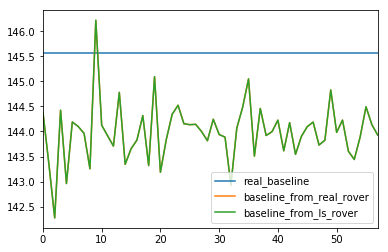

In [9]:
results.plot()

In [ ]:
r = []
def Norm(v):
    return np.linalg.norm(v, axis=0)

for i in range(len(data_common)):
    if i % 100 == 0:
        dat = copy.deepcopy(data_common.iloc[i])
        csats = dat.csats
        gps_sow = dat.gps_sow

        dis_rp, ri, a, a1, a2, c, b = baseline(dat, rec_pos1, ref_sat_id=4)
        dc, teta, dc_vec = d_teta_calc(rec_pos2, rec_pos1)

        #print np.linalg.norm(dis-dc_vec), np.linalg.norm(dis-dc_vec)/np.linalg.norm(dc_vec)*100
        dis_ls = test(rec_pos1, rec_pos2, apply_iono_model='standard', Obser="L1")
        #print np.linalg.norm(dis_rp - dis_ls)
        
        r.append([gps_sow, rec_pos1, rec_pos2, Norm(dc_vec), Norm(dis_rp), Norm(dis_ls)])    
names = ["gps_sow" ,"real_rover_pos", "real_master_pos", "real_baseline", "baseline_from_real_rover", "baseline_from_ls_rover"]
results = pd.DataFrame(r, columns=names)
results.plot()

In [ ]:
parejas_kmz        = get_data_stations("./Coconet_sites_2016.kmz", 1e3)
parejas_kmz

In [ ]:
i = 0
dat = data_common.iloc[i]
dc, teta, d_vec = d_teta_calc(rec_pos1, rec_pos2)
print d_vec

test(rec_pos1, rec_pos2, apply_iono_model='standard')

In [ ]:
def Solver_cooperative(common_info, rec_pos, x2, d, observable="C1", xo=np.array([0.]*4), apply_earth_rotation=False, model_iono=False):
    
    def cost(estimated, info, svs1, pr1, ts1, svs2, pr2, ts2, x2, d, model_iono, io1, io2):
        c_val = 2.99792458e8# 299792458
        #f = np.sqrt(np.sum((np.sqrt(np.sum((svs-estimated[:3])**2, axis=1)) + c*estimated[3] - c*(clocks)  - prs)**2)) #
        noise = 0
        fn1, fn2 = 0., 0.

        if model_iono:
            iono1 = estimated[4]*io1
            iono2 = estimated[5]*io2

            fn1 = np.sum((-pr1 + c_val*(estimated[3]- ts1) + np.linalg.norm((estimated[:3] - svs1), axis=1) + iono1 + noise)**2)
            fn2 = np.sum((-pr2 + c_val*(estimated[3]- ts2) + np.linalg.norm((estimated[:3]+d - svs2), axis=1) + iono2 + noise)**2)

        else:
            fn1 = np.sum((-pr1 + c_val*(estimated[3]- ts1) + np.linalg.norm((estimated[:3] -d - svs1), axis=1) + noise)**2)
            fn2 = np.sum((-pr2 + c_val*(estimated[3]- ts2) + np.linalg.norm((x2 - svs2), axis=1) + noise)**2)

        f = np.log(fn1 + fn2)

        return f

    svs1 = common_info["prns_pos_local"]
    svs2 = common_info["prns_pos_remote"]
    pr1  = common_info[observable+"_local"]
    ts1  = common_info["prns_clockbias_local"]

    pr2  = common_info[observable+"_remote"]
    ts2  = common_info["prns_clockbias_remote"]

    if apply_earth_rotation:
        svs1 = apply_earth_rotation_to_svs_position(svs1, pr1)
        svs2 = apply_earth_rotation_to_svs_position(svs2, pr2)

    io1, io2 = 0., 0.
    
    from scipy.optimize import minimize, basinhopping, fsolve
    f = lambda x: cost(x, common_info, svs1, pr1, ts1, svs2, pr2, ts2, x2, d, model_iono, io1, io2)

    minimizer_kwargs = {"method": "Powell"} # Powell, COBYLA, Nelder-Mead
    rm = basinhopping(f, xo, minimizer_kwargs=minimizer_kwargs, disp=False)

    print "position computed", rm.x
    print "position         ", rec_pos
    print "position error   ", np.linalg.norm(rm.x[:3] - rec_pos[:3])


In [ ]:
i = 0

dat = data_common.iloc[i]
dc, teta, dc_vec = d_teta_calc(rec_pos2, rec_pos1)
rc = Solver_cooperative(dat, rec_pos1, rec_pos2, dc_vec, "C1", xo=np.array([0.]*4))

In [ ]:
def least_squares_diff(svs, svs_clocks, prs, elevs, max_iters=200, apply_earth_rotation=True, apply_iono_model=None):

    def iono_3dmodel(rs, d_iono, elevs):
        num1 = d_iono**2*(np.sqrt(rs**2*np.cos(elevs))*np.sin(elevs)**2)
        den1 = np.power(2*rs*np.cos(elevs)**2, 3) #8*rs**3*np.cos(elev)**6 # 

        num2 = rs
        den2 = rs*np.cos(elevs)

        return num2/den2 + 1/8*(d_iono/rs)*(d_iono/rs)*np.tan(elevs) #num1/den1

    R_earth = 6367444.657  # 6,371 km
    h_iono  = 400e3

    #elv1 = common_info['prns_elev_local']
    #elv2 = common_info['prns_elev_remote']

    if apply_iono_model=='taylor':
        print "a", apply_iono_model
        rs, d_iono = R_earth+h_iono, 10e3
        io1 = iono_3dmodel(rs, d_iono, elevs)
        #io2 = iono_3dmodel(rs, d_iono, elv2)  

    elif apply_iono_model=='standard':
        print apply_iono_model
        R = R_earth
        io1 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elevs)))
        #io2 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elv2)))
    
    else:
        io1 = 0.
        pass
 

    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):
        rhos, pranges = predict_pseudoranges(ri, svs, svs_clocks)
        b = prs - pranges + io1# + iono_delay(elevs, iono_model='taylor')
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta

## Several iono_delay models

In [ ]:
i = 0
dat = data_common.iloc[i]

Obser = "C1"
elevs = data1['prns_elev']
print type(data1.iloc[i]['prns_elev']), type(dat['prns_elev_local'])
#print data1['prns_elev']
#print dat['prns_elev_local']

local,_,_,_ = least_squares_position(data1.iloc[i]['prns_pos'],
                                     data1.iloc[i]['prns_clockbias'],
                                     data1.iloc[i][Obser], 
                                     data1.iloc[i]['prns_elev'],
                                     apply_iono_model='taylor')
print "Solver Standalone", local[:3], np.linalg.norm(local[:3] - rec_pos1)

In [ ]:
local,_,_,_ = least_squares_position(data1.iloc[i]['prns_pos'],
                                     data1.iloc[i]['prns_clockbias'],
                                     data1.iloc[i][Obser], 
                                     data1.iloc[i]['prns_elev'],
                                     apply_iono_model='standard')
print "Solver Standalone", local[:3], np.linalg.norm(local[:3] - rec_pos1)

In [ ]:
local,_,_,_ = least_squares_position(data1.iloc[i]['prns_pos'],
                                     data1.iloc[i]['prns_clockbias'],
                                     data1.iloc[i][Obser], 
                                     data1.iloc[i]['prns_elev'])
print "Solver Standalone", local[:3], np.linalg.norm(local[:3] - rec_pos1)

In [ ]:
def Solver_cooperative(common_info, d, reference_pos, observable="C1", xo=np.array([0.]*4), apply_earth_rotation=True, model_iono=False):
    
    def iono_model(rs, d_iono, elev):
        num1 = d_iono**2*(np.sqrt(rs**2*np.cos(elev))*np.sin(elev)**2)
        den1 = np.power(2*rs*np.cos(elev)**2, 3) #8*rs**3*np.cos(elev)**6 # 
        
        num2 = rs
        den2 = rs*np.cos(elev)
        
        return num2/den2 + 1/8*(d_iono/rs)*(d_iono/rs)*np.tan(elev) #num1/den1
    
    
    def cost(estimated, info, svs1, pr1, ts1, svs2, pr2, ts2, d, reference_pos, model_iono, io1, io2):
        c_val = 2.99792458e8# 299792458
        #f = np.sqrt(np.sum((np.sqrt(np.sum((svs-estimated[:3])**2, axis=1)) + c*estimated[3] - c*(clocks)  - prs)**2)) #
        noise = 0
        fn1, fn2 = 0., 0.
                       
        rover_pos = estimated[:3]-d
        reference = reference_pos
        
        if model_iono:
            iono1 = estimated[4]*io1
            iono2 = estimated[5]*io2
            
            fn1 = np.sum((-pr1 + c_val*(estimated[3]- ts1) + np.linalg.norm((rover_pos - svs1), axis=1) + iono1 + noise)**2)
            fn2 = np.sum((-pr2 + c_val*(estimated[3]- ts2) + np.linalg.norm((reference - svs2), axis=1) + iono2 + noise)**2)
            
        else:
            fn1 = np.sum((-pr1 + c_val*(estimated[3]- ts1) + np.linalg.norm((rover_pos - svs1), axis=1) + noise)**2)
            fn2 = np.sum((-pr2 + c_val*(estimated[3]- ts2) + np.linalg.norm((reference - svs2), axis=1) + noise)**2)

        f = np.log(fn1 + fn2)
    
        return f

    svs1 = common_info["prns_pos_local"]
    svs2 = common_info["prns_pos_remote"]
    pr1  = common_info[observable+"_local"]
    ts1  = common_info["prns_clockbias_local"]

    pr2  = common_info[observable+"_remote"]
    ts2  = common_info["prns_clockbias_remote"]
    
    if apply_earth_rotation:
        svs1 = apply_earth_rotation_to_svs_position(svs1, pr1)
        svs2 = apply_earth_rotation_to_svs_position(svs2, pr2)
        
    if model_iono:
        
        xo = np.array(list(xo)+[0.]*2)
                    
        R_earth = 6367444.657  # 6,371 km
        h_iono  = 400e3

        elv1 = common_info['prns_elev_local']
        elv2 = common_info['prns_elev_remote']

        #iono1 = vtec(pr1, pr2, elv1)
        #iono2 = vtec(pr2, pr1, elv2)

        a1 = R_earth*np.cos(elv1)/(R_earth + h_iono)
        a2 = R_earth*np.cos(elv2)/(R_earth + h_iono)

        op = True
        
        if op:
            R = R_earth
            io1 = 1/np.cos(np.arcsin(R/(R+350000))*np.sin(elv1))
            io2 = 1/np.cos(np.arcsin(R/(R+350000))*np.sin(elv2))

        else:
            rs, d_iono = R_earth+h_iono, 10e3
            io1 = iono_model(rs, d_iono, elv1)
            io2 = iono_model(rs, d_iono, elv2)
        
    else:
        io1 = 0.
        io2 = 0.  
            
    from scipy.optimize import minimize, basinhopping, fsolve
    f = lambda x: cost(x, common_info, svs1, pr1, ts1, svs2, pr2, ts2, d, reference_pos, model_iono, io1, io2)

    print "here" ,reference_pos, d
    minimizer_kwargs = {"method": "COBYLA"} # Powell, COBYLA, Nelder-Mead
    rm = basinhopping(f, xo, T=1e-6, minimizer_kwargs=minimizer_kwargs, disp=False)

    """
    print "position computed", rm.x
    print "position         ", rec_pos
    print "position error   ", np.linalg.norm(rm.x[:3] - rec_pos[:3])
    """
    return rm

In [ ]:
def test(rec_pos1, rec_pos2, coop_ini="ls", Obser="C1", dc_vec=None, apply_iono_model=None):
    
    if len(dat['csats'])>=4:

        start_time = time.time()
        # Metodos desarrollados
        if coop_ini == "ls":
            #elevs = data1['prns_elev_local']
            local,_,_,_ = least_squares_position(dat['prns_pos_local'],
                                                 dat['prns_clockbias_local'],
                                                 dat[Obser+'_local'],
                                                 dat['prns_elev_local'],
                                                 apply_iono_model=apply_iono_model)
            remote,_,_,_ = least_squares_position(dat['prns_pos_remote'],
                                                  dat['prns_clockbias_remote'],
                                                  dat[Obser+'_remote'],
                                                  dat['prns_elev_remote'],
                                                  apply_iono_model=apply_iono_model)
            if dc_vec == None:   
                dc, teta, dc_vec = d_teta_calc(local[:3], remote[:3])

        else:
            local  = Solver_standalone(dat['prns_pos_local'], dat['prns_clockbias_local'], dat[Obser+'_local'])
            remote = Solver_standalone(dat['prns_pos_remote'], dat['prns_clockbias_remote'], dat[Obser+'_remote'])
            
            if dc_vec == None:
                dc, teta, dc_vec = d_teta_calc(local.x[:3], remote.x[:3])
                
            local = local.x
        
        print "dc_v", dc_vec
        reference_pos = rec_pos2
        print "reference_position", reference_pos
        rc  = Solver_cooperative(dat, dc_vec, reference_pos, "C1", xo=np.array(list(local[:3])+[0.]))
        rc1 = Solver_cooperative(dat, dc_vec, rec_pos1, "C1", xo=np.array(list(remote[:3])+[0.]))
        coop_t = time.time() - start_time

        loc, loc_err = rc.x[:3],  np.linalg.norm(rc.x[:3] - rec_pos1)
        rem, rem_err = rc1.x[:3],  np.linalg.norm(rc1.x[:3] - rec_pos2)

    print ("Posicion real Rx_%s = %s" %(1, rec_pos1))
    print ("Posicion real Rx_%s = %s" %(2, rec_pos2))

    print "Solver Standalone", local[:3], np.linalg.norm(local[:3] - rec_pos1)
    print "Solver Cooperativ", loc, np.linalg.norm(loc - rec_pos1)

In [ ]:
i = 0
dat = data_common.iloc[i]
dc, teta, d_vec = d_teta_calc(rec_pos1, rec_pos2)
print d_vec

test(rec_pos1, rec_pos2, apply_iono_model='standard', dc_vec=d_vec)

In [ ]:
test(rec_pos1, rec_pos2, apply_iono_model='taylor')

# Ejecutando los metodos desarrollados para estaciones con distancias inferiores a 10km

In [ ]:
%matplotlib inline
%run -i ./code/utils.py
%run -i ./code/Wallas_Solvers.py
%run -i ./code/WallasUtils.py
%run -i ./code/results_toolkit.py

In [ ]:
dia1 = "010"
dian = "010"
ano = "2017"

Observable = "C1"
# Variables de la grafica
error_max = 100

# Ubicacion de la Rinex local DB 
Rinex_dataBase      = "./new_data/"
Simu_Folder         = getcwd() +"/" + "Temp_Simul_data"

# agregando nuevos pares de estaciones (que no estan en el kmz)
parejas_kmz = {}

parejas_kmz        = get_data_stations("./sites.kmz", 10e3)
#RinexDB = descarga_Rinex_Compri(Rinex_dataBase, parejas_kmz, dia1, dian, ano)

## Leer los rinex almacenado en mi equipo
RinexDB = read_Rinex_Compri(Rinex_dataBase, parejas_kmz)

In [ ]:
results2 = run_simulation(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, run_stdlo=True, run_coop=True, res_plot=900)

In [ ]:
def dist_analisis(results2):
    
    for key in results2["cooperative"].keys():
        print key
        df = results2["cooperative"][key][["real_pos_local", "real_pos_remote", "dc_vec"]]
        #dr = df.append([df["real_pos_local"] - df["real_pos_remote"]])
        #dr = df
        dr = pd.DataFrame()
        dr[key+'_real_d'] = df[['real_pos_local']].sub(df['real_pos_remote'], axis=0)
        dr[key+'_real_d'] = dr[key+'_real_d'].apply(lambda x: np.sqrt(x.dot(x)))
        dr[key+'_calc_d'] = df['dc_vec'].apply(lambda x: np.sqrt(x.dot(x)))

    return dr

In [ ]:
dc = dist_analisis(results2)
dc

In [ ]:
from IPython.display import display
%matplotlib inline

fig = plt.figure(figsize=(10,5))

for k, col in dc.iteritems(): #['calc_d', 'real_d']:
    #print k, col
    ax = fig.add_subplot(211)
    dc[k].plot(legend=True)
#dc.plot(x=dc.index, y='calc_d')
#dc.plot(x=dc.index, y='real_d')

In [ ]:
%matplotlib nbagg
%run -i ./code/results_toolkit.py

stlone_vars = ['raim_err', 'ls_err', 'optim_err']
cooper_vars = ['coop_err_local', 'coop_err_remote']
plot_df_errors(results2, stlone_vars, cooper_vars)

Para este experimento ha realizado los siguientes cambios:

* he empleado posicionamiento standalone (con least squares) para el par de estaciones; para el calculo de la distancia inicial que ingresa al método cooperativo.
* con el cambio anterior, el tiempo de ejecución para el metodo cooperativo se reduce, como es de esperarse (menor carga computacional)

In [ ]:
def compare_error_standalone_vs_cooperative(results2, station_pair):
    
    key = "('"+station_pair[0]+"', '"+station_pair[1]+"')"
    
    for key in results2["cooperative"].keys():

        stations = [k.replace(" ", "") for k in key.split(",")]
        local, remote = stations[0].split("(")[1].replace("'", ""), stations[1].split(")")[0].replace("'", "")

        dfc = results2["cooperative"][key][["coop_err_local", "coop_err_remote"]]
        dfl = results2["standalone"][local][["raim_err", "ls_err", "optim_err"]]
        dfr = results2["standalone"][remote][["raim_err", "ls_err", "optim_err"]]

        df = pd.concat([dfl, dfr, dfc], axis=1)
        df = df.astype(float)
        #df = dfl.T.append([dfr.T, dfc.T])

    return df

# estadisticas de error para par de estaciones 'tgmx0100.17', 'unpm0100.17''

In [ ]:
# extract errors
from IPython.display import display
station_pair = ['tgdr0100.17', 'bara0100.17']

df = compare_error_standalone_vs_cooperative(results2, station_pair)
print "\t \t error positioning for"
print "*"*40
print "local_station %s \t remote_station %s\tstation_pair %s"%(station_pair[0], station_pair[1], tuple(station_pair))
#display(df)
print "\t \t estadisticas de error para pareja %s"%(str(tuple(station_pair)))
print "*"*80
df.describe()

para los resultados estadisticos en la pareja de estaciones `(tgdr, bara)` y `(tgmx, unpm)` para el **dia GPS 10 de 2017**; se ve que el metodo raim tiene menor error de posicionamiento que los metodos `least squares` y **solver (un optimizador caja negra)**

Sin embargo, el promedio del error para **el metodo cooperativo** mejora con respecto al posicionamiento en standalone con **least squares**

# estadisticas de error para par de estaciones 'tgdr0100.17', 'bara0100.17'

In [ ]:
station_pair = ['tgmx0100.17', 'unpm0100.17']

df = compare_error_standalone_vs_cooperative(results2, station_pair)
print "\t \t error positioning for"
print "*"*40
print "local_station %s \t remote_station %s\tstation_pair %s"%(station_pair[0], station_pair[1], tuple(station_pair))
#display(df)
print "\t \t estadisticas de error para pareja %s"%(str(tuple(station_pair)))
print "*"*80
df.describe()

# Tabla de resultados

In [ ]:
show_results(results2)